Implementing, training, and analyzing tasks from [International Brain Lab](https://www.sciencedirect.com/science/article/pii/S0896627317311364)


by Guangyu Robert Yang and Larry Abbott

In [0]:
# Install gym
!pip install -q gym

In [0]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.size'] = 7
mpl.rcParams['font.family'] = 'Arial'

import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim


In [0]:
# Define tasks

class IBL(gym.Env):
    def __init__(self):
        super(IBL).__init__()

        self.rng = np.random.RandomState(0)
        self.sigma = 0.10  # noise
        self.num_tr = 0  # number of trials
        self.block = 0  # block id
        self.block_size = 10000

        # Rewards
        self.R_CORRECT = +1.
        self.R_FAIL = 0.

        # trial conditions (left, right)
        self.choices = [0, 1]

        self.cohs = np.array([1.6, 3.2, 6.4, 12.8, 25.6, 51.2])

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-np.inf, np.inf, shape=(2,),
                                            dtype=np.float32)

        self.seed()
        self.viewer = None
        

    def new_block(self, n_trial, probs=None):
        self.ground_truth = self.rng.choice(self.choices, size=(n_trial,), p=probs)
        self.coh = self.rng.choice(self.cohs, size=(n_trial,))

        obs = np.zeros((n_trial, self.observation_space.shape[0]))
        ind = np.arange(n_trial)
        obs[ind, self.ground_truth] = 0.5 + self.coh / 200
        obs[ind, 1 - self.ground_truth] = 0.5 - self.coh / 200

        # Add observation noise
        obs += self.rng.randn(*obs.shape) * self.sigma
        self.obs = obs

    def _new_trial(self):
        """
        _new_trial() is called when a trial ends to get the specifications of
        the next trial. Such specifications are stored in a dictionary with
        the following items:
            durations, which stores the duration of the different periods (in
            the case of rdm: fixation, stimulus and decision periods)
            ground truth: correct response for the trial
            coh: stimulus coherence (evidence) for the trial
        """
        # ---------------------------------------------------------------------
        # Trial
        # ---------------------------------------------------------------------
        self.ind = self.num_tr % self.block_size
        if self.ind == 0:
            self.new_block(self.block_size)

        self.num_tr += 1

    def _step(self, action):
        trial = self.trial
        info = {'continue': True, 'gt': self.ground_truth[self.ind],
                'coh': self.coh[self.ind], 'block': self.block}
        obs = self.obs[self.ind]

        # reward of last trial
        reward = self.R_CORRECT  # TODO: need to be done

        # ---------------------------------------------------------------------
        # new trial?
        info['new_trial'] = True
        done = False
        return obs, reward, done, info

    def step(self, action):
        obs, reward, done, info = self._step(action)
        if info['new_trial']:
            self.trial = self._new_trial()
        return obs, reward, done, info

    def reset(self):
        self.trial = self._new_trial()
        obs, reward, done, info = self._step(action=0)
        return obs, reward, done, info


class IBL_Block(IBL):
    # pass
    def __init__(self):
        super().__init__()
        self.probs = ((0.2, 0.8), (0.8, 0.2), (0.5, 0.5))
        self.block = 0
        self.block_size = 200

    def _new_trial(self):
        """
        _new_trial() is called when a trial ends to get the specifications of
        the next trial. Such specifications are stored in a dictionary with
        the following items:
            durations, which stores the duration of the different periods (in
            the case of rdm: fixation, stimulus and decision periods)
            ground truth: correct response for the trial
            coh: stimulus coherence (evidence) for the trial
        """
        # ---------------------------------------------------------------------
        # Trial
        # ---------------------------------------------------------------------
        self.ind = self.num_tr % self.block_size
        if self.ind == 0:
            self.block = self.rng.choice([0, 1, 2])
            prob = self.probs[self.block]
            self.new_block(self.block_size, probs=prob)

        self.num_tr += 1

In [0]:
# Get supervised learning data
from collections import defaultdict
# env = IBL()
env = IBL_Block()
env.reset()

def get_supervised_data(n_steps, get_meta_data=False):
    meta_data = defaultdict(list)
    # TODO: Not reseting here is the right thing to do,
    # but may have a small impact on results
    # env.reset() 
    X = np.zeros((n_steps, env.observation_space.shape[0]))
    Y = np.zeros((n_steps,))
    for i in range(n_steps):
        obs, reward, done, info = env.step(action=0)
        X[i] = obs
        Y[i] = info['gt']
        if get_meta_data:
            for key, val in info.items():
                meta_data[key].append(val)

    X = X[:, np.newaxis, :].astype(np.float32)
    Y = Y[:, np.newaxis].astype(np.int)
    if get_meta_data:
        for key, val in meta_data.items():
            meta_data[key] = np.array(val)

    return X, Y, meta_data

In [0]:
# Test if the data can be generated
X, Y, _ = get_supervised_data(100)
# plt.scatter(X[:, 0, 0], Y[:, 0])

In [0]:
# Define networks

class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.rnn = nn.LSTM(input_size, hidden_size)
        self.rnn_state = None
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # input size (seq_len, batch_size, input_size)
        # output size (seq_len, batch_size, output_size)
        # TODO: store h0, c0
        batch_size = x.shape[1]
        if self.rnn_state is None:
            x, self.rnn_state = self.rnn(x)
            # x, _ = self.rnn(x)
        else:
            x, self.rnn_state = self.rnn(x, self.rnn_state)
        self.rnn_state = (self.rnn_state[0].detach(), self.rnn_state[1].detach())
        x = self.fc(x)
        return x



In [7]:
# Training networks
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Using device ', device)

input_size = env.observation_space.shape[0]
hidden_size = 100
output_size = env.action_space.n
batch_size = 1
seq_len = 1000

net = Net(input_size, hidden_size, output_size)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

running_loss = 0.0
running_acc = 0.0
print_every_steps = 50
for i in range(1000):
    X, Y, _ = get_supervised_data(seq_len)

    # get the inputs; data is a list of [inputs, labels]
    inputs = torch.from_numpy(X).to(device)
    labels = torch.from_numpy(Y).to(device)
    labels = labels.view(-1)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    outputs = outputs.view(-1, output_size)
    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, axis=-1) == labels).float().mean()
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    running_acc += acc.item()
    if i % print_every_steps == 0:    # print every 2000 mini-batches
        running_loss /= print_every_steps
        running_acc /= print_every_steps
        print('[{:5d}] loss: {:0.3f}, acc: {:0.3f}'.format(
            i + 1, running_loss, running_acc))
        running_loss = 0.0
        running_acc = 0.0

print('Finished Training')

Using device  cuda
[    1] loss: 0.014, acc: 0.009
[   51] loss: 0.687, acc: 0.542
[  101] loss: 0.667, acc: 0.652
[  151] loss: 0.666, acc: 0.584
[  201] loss: 0.658, acc: 0.684
[  251] loss: 0.640, acc: 0.734
[  301] loss: 0.584, acc: 0.701
[  351] loss: 0.561, acc: 0.716
[  401] loss: 0.565, acc: 0.709
[  451] loss: 0.560, acc: 0.715
[  501] loss: 0.538, acc: 0.732
[  551] loss: 0.527, acc: 0.743
[  601] loss: 0.512, acc: 0.755
[  651] loss: 0.474, acc: 0.782
[  701] loss: 0.493, acc: 0.772
[  751] loss: 0.445, acc: 0.795
[  801] loss: 0.418, acc: 0.808
[  851] loss: 0.422, acc: 0.799
[  901] loss: 0.407, acc: 0.810
[  951] loss: 0.407, acc: 0.806
Finished Training


In [8]:
import time
# Analyze networks. This can take up to 30 seconds
start_time = time.time()
env.reset()
X, Y, meta_data = get_supervised_data(200000, get_meta_data=True)
print('Generating data time taken', time.time() - start_time)
# get the inputs; data is a list of [inputs, labels]
inputs = torch.from_numpy(X).to(device)
labels = torch.from_numpy(Y).to(device)
labels = labels.view(-1)

# forward + backward + optimize
start_time = time.time()
outputs = net(inputs)
print('Network time taken', time.time() - start_time)
outputs = outputs.detach().cpu().numpy()[:, 0, :]

Generating data time taken 0.9658584594726562
Network time taken 7.758907079696655


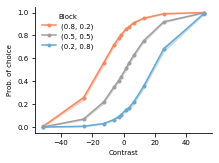

In [10]:
meta_data['target_choice'] = meta_data['gt']
meta_data['signed_coh'] = meta_data['coh'] * (meta_data['target_choice']*2-1)
meta_data['actual_choice'] = np.argmax(outputs, axis=1)

def get_sorted_values(sort_by, avg_var, condition_var=None, condition_val=None):
    unique_vals = np.unique(meta_data[sort_by])
    values = list()
    mean_values = list()
    confint_lows = list()
    confint_highs = list()
    for val in unique_vals:
        ind = meta_data[sort_by] == val
        if condition_var is not None:
            ind_condition = meta_data[condition_var] == condition_val
            ind *= ind_condition
        value = meta_data[avg_var][ind]
        values.append(value)
        mean_values.append(np.mean(value))

        means = [np.mean(np.random.choice(value, size=len(value))) for i in range(100)]
        confint = np.percentile(means, [2.5, 97.5])
        confint_lows.append(confint[0])
        confint_highs.append(confint[1])

    return unique_vals, mean_values, confint_lows, confint_highs

sort_by = 'signed_coh'  # sort by this variable
avg_var = 'actual_choice'  # average this variable

nicenames = {'signed_coh': 'Contrast',
             'actual_choice': 'Prob. of choice'}

fig = plt.figure(figsize=(3.5, 2.5))
ax = fig.add_axes([0.2, 0.2, 0.7, 0.7])
# unique_vals, mean_values = get_sorted_values(sort_by, avg_var)
# plt.plot(unique_vals, mean_values, 'o-', label='both')
colors = [np.array([239,138,98])/255.,
          np.array([159]*3)/255.,
          np.array([103,169,207])/255.]
for i, block in enumerate([0, 2, 1]):
    color = colors[i]
    probs = env.probs[block]
    label = '({:0.1f}, {:0.1f})'.format(probs[1], probs[0])
    unique_vals, mean_values, confint_lows, confint_highs = get_sorted_values(
        sort_by, avg_var, condition_var='block', condition_val=block)
    ax.plot(unique_vals, mean_values, 'o-', label=label, markersize=3,
            color=color)
    ax.fill_between(unique_vals, confint_lows, confint_highs, color=color, alpha=0.3)
plt.xlabel(nicenames[sort_by])
plt.ylabel(nicenames[avg_var])
plt.legend(title='Block', frameon=False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

figname = "psychometric_IBLBlock.pdf"
plt.savefig(figname, transparent=True)

# Colab specific
from google.colab import files
files.download("psychometric_IBLBlock.pdf")